# Exploratory Data Analysis

In this EDA, I will be examining various data sources from [opendata.vancouver.ca](https://opendata.vancouver.ca/pages/home/).

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import requests
import os
import time
import pickle
import json
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.functions import coalesce, max

In [3]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when, last, first, regexp_extract
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.types import *

## Reading in the main dataset

In [4]:
spark = SparkSession.builder.appName('Ops').getOrCreate()

In [5]:
# allows for cleaner output
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

> This creates a Spark DataFrame which is very similar to a Pandas DataFrame. Spark DataFrames build on top of RDDs and also has great SQL integration for users who are familiar with the popular language. The main difference with Spark DataFrames is that operations can run on multiple nodes and they are lazy evaluators meaning operations won't be executed until the output is needed.

In [6]:
licences_df = (spark.read
          .option('header','true')
          .option('inferSchema','true')
          .option('sep', ';')
          .csv('../data/business-licences.csv'))

In [7]:
f'There are %i observations in this dataset' % licences_df.count() 

'There are 504842 observations in this dataset'

In [8]:
licences_df.printSchema()

root
 |-- FOLDERYEAR: integer (nullable = true)
 |-- LicenceRSN: integer (nullable = true)
 |-- LicenceNumber: string (nullable = true)
 |-- LicenceRevisionNumber: integer (nullable = true)
 |-- BusinessName: string (nullable = true)
 |-- BusinessTradeName: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- IssuedDate: timestamp (nullable = true)
 |-- ExpiredDate: timestamp (nullable = true)
 |-- BusinessType: string (nullable = true)
 |-- BusinessSubType: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- House: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- LocalArea: string (nullable = true)
 |-- NumberofEmployees: double (nullable = true)
 |-- FeePaid: integer (nullable = true)
 |-- ExtractDate: timestamp (nullable = true)
 |-- Geom: st

In [9]:
licences_df = licences_df.withColumnRenamed('FOLDERYEAR', 'year')\
           .withColumnRenamed('LicenceRSN', 'licence_rsn')\
           .withColumnRenamed('LicenceNumber', 'licence_num')\
           .withColumnRenamed('LicenceRevisionNumber', 'licence_revision_num')\
           .withColumnRenamed('BusinessName', 'name')\
           .withColumnRenamed('BusinessTradeName', 'trade_name')\
           .withColumnRenamed('Status', 'status')\
           .withColumnRenamed('IssueDate', 'issue_date')\
           .withColumnRenamed('ExpiredDate', 'expired_date')\
           .withColumnRenamed('BusinessType', 'type')\
           .withColumnRenamed('BusinessSubType', 'subtype')\
           .withColumnRenamed('Unit', 'unit')\
           .withColumnRenamed('UnitType', 'unit_type')\
           .withColumnRenamed('House', 'house')\
           .withColumnRenamed('Street', 'street')\
           .withColumnRenamed('City', 'city')\
           .withColumnRenamed('Province', 'province')\
           .withColumnRenamed('Country', 'country')\
           .withColumnRenamed('PostalCode', 'postal_code')\
           .withColumnRenamed('LocalArea', 'area')\
           .withColumnRenamed('NumberofEmployees', 'n_employees')\
           .withColumnRenamed('FeePaid', 'fee')\
           .withColumnRenamed('ExtractDate', 'extract_date')\
           .withColumnRenamed('Geom', 'geom')

In [297]:
# show the first 10 rows 
licences_df.limit(10)

year,licence_rsn,licence_num,licence_revision_num,name,trade_name,status,IssuedDate,expired_date,type,subtype,unit,unit_type,house,street,city,province,country,postal_code,area,n_employees,fee,extract_date,geom
15,2345113,15-115406,0,(Shun Chen),ACC Security Syst...,Gone Out of Business,null,null,Electrical-Securi...,null,null,null,null,null,Surrey,BC,CA,null,null,2.0,null,2019-07-21 13:48:02,null
15,2345119,15-115412,0,Praetorian Securi...,Amax Praetorian,Issued,2014-12-01 14:04:29,2015-12-31 00:00:00,Electrical-Securi...,null,null,null,null,null,Chilliwack,BC,CA,null,null,0.0,133,2019-07-21 13:48:02,null
15,2345120,15-115413,0,Safe-Tec Security...,null,Gone Out of Business,null,null,Electrical-Securi...,null,null,null,null,null,Surrey,BC,CA,null,null,0.0,null,2019-07-21 13:48:02,null
15,2345121,15-115414,0,Husky Alarm Integ...,null,Issued,2015-02-10 08:05:11,2015-12-31 00:00:00,Electrical-Securi...,null,null,null,null,null,Port Moody,BC,CA,null,null,2.0,173,2019-07-21 13:48:02,null
15,2345122,15-115415,0,Sea to Sky Securi...,null,Pending,null,null,Electrical-Securi...,null,null,null,null,null,North Vancouver,BC,CA,null,null,3.0,null,2019-07-21 13:48:02,null
15,2345188,15-115481,0,(Kenneth Bradley),Ken Bradley Truck...,Issued,2014-11-18 11:35:48,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Coquitlam,BC,CA,null,null,0.0,162,2019-07-21 13:48:02,null
15,2345191,15-115484,0,Litz Crane Servic...,null,Issued,2014-11-06 14:31:00,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Port Coquitlam,BC,CA,null,null,5.0,162,2019-07-21 13:48:02,null
15,2345195,15-115488,0,(Wayne Nichols),W Nichols Trucking,Issued,2014-11-05 12:50:58,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Delta,BC,CA,null,null,1.0,162,2019-07-21 13:48:02,null
15,2345196,15-115489,0,(Harry Powar),Harry Powar Trucking,Issued,2014-12-04 18:49:08,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Burnaby,BC,CA,null,null,1.0,162,2019-07-21 13:48:02,null
15,2345203,15-115496,0,J Brown Trucking Inc,null,Issued,2014-12-06 09:23:32,2015-12-31 00:00:00,Equipment Operator,null,null,null,null,null,Delta,BC,CA,null,null,2.0,162,2019-07-21 13:48:02,null


In [273]:
licences_df.groupBy('year').count()

year,count
13,60915
16,61394
20,64003
19,70771
15,60938
17,60060
14,60581
18,66180


## Initial Wrangling 

In [10]:
business_types = licences_df.select('type').distinct().collect()
business_list = [business_types[i].type for i in range(len(business_types))]

r = re.compile(".*[Ff]ood.*|.*[Rr]estaurant.*|.*[Ll]iquor.*")
relevant_list = list(filter(r.match, business_list)) 
print(relevant_list)

['Manufacturer - Food with Anc. Retail', 'Ltd Service Food Establishment', 'Temp Liquor Licence Amendment', 'Liquor Delivery Services', 'Liquor Establishment Standard', 'Retail Dealer - Food', 'Restaurant Class 2', 'Food Processing', 'Liquor Establishment Extended', 'Wholesale Dealer - Food with Anc. Retail', 'Restaurant Class 1', 'Liquor License Application', 'Warehouse Operator - Food', 'Manufacturer - Food', 'Liquor Retail Store', 'Wholesale Dealer - Food']


> These are the list of business types that have the word food, restaurant, or liquor.

In [11]:
rest_1 = (licences_df.type == 'Restaurant Class 1')
rest_2 = (licences_df.type == 'Restaurant Class 2')
rest_3 = (licences_df.type == 'Ltd Service Food Establishment')
rest_4 = (licences_df.type == 'Temp Liquor Licence Amendment') & (licences_df.subtype == 'Area Extension')
rest_5 = (licences_df.type == 'Liquor Establishment Standard') & (licences_df.subtype == 'Class 1  0-65 Seats')
rest_6 = (licences_df.type == 'Liquor Establishment Extended') & (licences_df.subtype == 'Class 1  0-65 Seats')


licences_rest_df = licences_df.filter(rest_1 | rest_2 | rest_3 | rest_4 | rest_5 | rest_6)

In [12]:
licences_rest_df.groupBy("status").count()

status,count
Cancelled,604
Gone Out of Business,2914
Issued,24579
Inactive,662
Pending,1420


In [309]:
f'There are %i businesses with missing name values' % licences_rest_df.filter('trade_name is null').select('name').distinct().count()

'There are 955 businesses with missing name values'

> I will replace these entries with their business names. 

In [13]:
licences_rest_df = licences_rest_df.withColumn('trade_name', coalesce('trade_name', 'name'))

In [14]:
licences_rest_df = licences_rest_df.dropna(subset = ['name'])

In [312]:
licences_rest_df.count()

30148

In [15]:
# Search for names using regex

def search_restaurant(search_term, n = 20):
    rows = licences_rest_df.trade_name.rlike('.*{}.*'.format(search_term))
    return licences_rest_df.filter(rows).limit(n)

In [66]:
search_restaurant('Shizen', 5)

year,licence_rsn,licence_num,licence_revision_num,name,trade_name,status,IssuedDate,expired_date,type,subtype,unit,unit_type,house,street,city,province,country,postal_code,area,n_employees,fee,extract_date,geom
16,2603912,16-145075,0,Nagomi Project Ltd,Shizen Ya,Issued,2015-11-05 11:26:12,2016-12-31 00:00:00,Restaurant Class 1,With Liquor Service,null,null,1102,W BROADWAY,Vancouver,BC,CA,V6H 1G5,Fairview,10.0,1042,2019-07-21 13:49:20,"""{""""type"""": """"Poi..."
17,2819772,17-143449,0,Nagomi Project Ltd,Shizen Ya,Issued,2016-11-29 09:10:08,2017-12-31 00:00:00,Restaurant Class 1,With Liquor Service,null,null,1102,W BROADWAY,Vancouver,BC,CA,V6H 1G5,Fairview,10.0,1063,2020-01-01 02:32:04,"""{""""type"""": """"Poi..."
14,2157871,14-145460,0,Nagomi Project Ltd,Shizen Ya,Issued,2013-12-13 10:56:37,2014-12-31 00:00:00,Restaurant Class 1,With Liquor Service,null,null,1102,W BROADWAY,Vancouver,BC,CA,V6H 1G5,Fairview,8.0,999,2019-07-21 13:49:12,"""{""""type"""": """"Poi..."
15,2376219,15-146481,0,Nagomi Project Ltd,Natural Food Shiz...,Issued,2014-10-31 16:52:01,2015-12-31 00:00:00,Restaurant Class 1,With Liquor Service,null,null,985,HORNBY ST,Vancouver,BC,CA,V6Z 1V3,Downtown,10.0,878,2019-07-21 13:49:16,"""{""""type"""": """"Poi..."
14,2158834,14-146423,0,Nagomi Project Ltd,Natural Food Shiz...,Issued,2013-12-10 22:39:49,2014-12-31 00:00:00,Restaurant Class 1,With Liquor Service,null,null,985,HORNBY ST,Vancouver,BC,CA,V6Z 1V3,Downtown,7.0,860,2019-07-21 13:49:12,"""{""""type"""": """"Poi..."


In [344]:
# number of missing values of each column
licences_rest_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in licences_rest_df.columns))

year,licence_rsn,licence_num,licence_revision_num,name,trade_name,status,IssuedDate,expired_date,type,subtype,unit,unit_type,house,street,city,province,country,postal_code,area,n_employees,fee,extract_date,geom
0,0,0,0,0,0,0,3261,3260,0,12929,25242,25238,17,17,0,0,2,243,87,0,2537,0,831


In [16]:
# use this table to populate the features from yelp

rest_distinct_df = licences_rest_df.select(['year', 'status', 
                                            'trade_name', 'geom', 
                                            'postal_code', 'unit', 'house', 
                                            'street', 'city']).distinct()

In [284]:
f'There are %i restaurant locations' % licences_rest_df.select(['geom', 'postal_code', 'unit', 
                                                                'house', 'street', 'city']).distinct().count()

'There are 4462 restaurant locations'

In [27]:
f'There are %i closed/open restaurants locations' % licences_rest_df.select(['trade_name', 'geom', 'postal_code', 
                                                                             'unit', 'house', 'street', 'city']).distinct().count()

# this includes restuarants that changed locations

'There are 6637 closed/open restaurants locations'

In [285]:
rest_distinct_df.filter('house is null')\
                .filter('street is null')\
                .select('trade_name')\
                .distinct()

trade_name
Fresh Counter & C...
Siga-Siga's Chine...
Siga-Siga's Filip...
Panz Veggie
Craft Beer Market...
Fiery Pizza


> The Yelp API requires an address of these restaurants and 6 restaurants do not have any address. Since this is an insignificant proportion of the data, I will simply remove them.

In [17]:
rest_distinct_df = rest_distinct_df.dropna(how = 'all', subset = ['house', 'street'])

> Problem: can't get information for old closed restuarants 
> - initial thoughts: have to find an external API that has archived webpages
> - maybe a solution: businesses/search doesn't give closed restuarants but businesses/matches does (have to have exact address) and then get the ID from this output and input into businesses/{id}

In [18]:
# Here I am ordering the status such that if in a single year, there are multiple statuses, I will take the greatest

rest_distinct_df = rest_distinct_df.withColumn('status', 
                            when(col('status') == 'Inactive', 0)
                            .when(col('status') == 'Cancelled', 1)
                            .when(col('status') == 'Gone Out of Business', 2)
                            .when(col('status') == 'Pending', 3)
                            .when(col('status') == 'Issued', 4))

In [19]:
# This will get the latest location of a restaurant
# if in a single year, the restuarant is both cancelled and gone out of businesss, aggregate into 1 category
# if in a single year, the restuarant is both cancelled and issued, aggregate into 1 category - this means the restuarant moved locations
latest_year = rest_distinct_df.sort(['year', 'status'])\
                              .groupBy('trade_name')\
                              .agg(last('status').alias('status'), 
                                   last('year').alias('year'))

rest_distinct_df = rest_distinct_df.join(latest_year, on = ['status', 'year', 'trade_name'], how = 'leftsemi')

In [350]:
rest_distinct_df.count()

5740

In [20]:
# create new columns for longitude and latitude
rest_distinct_df = rest_distinct_df.withColumn('longitude', regexp_extract(col('geom'), '\[(.+), (.+)\]', 1).cast('float'))\
                                   .withColumn('latitude', regexp_extract(col('geom'), '\[(.+), (.+)\]', 2).cast('float'))\
                                   .drop('geom')

In [34]:
rest_distinct_df.limit(5)

Status,FOLDERYEAR,BusinessTradeName,PostalCode,Unit,House,Street,City,longitude,latitude
1,17,George Simnos & J...,V5V 4E9,null,4153,FRASER ST,Vancouver,-123.09054,49.248013
2,15,Sodexo @Vancouver...,V5T 4V5,null,1120,E 7TH AV,Vancouver,-123.08036,49.2633
2,16,Cilantro Cafe,V6Z 2L2,110,840,HOWE ST,Vancouver,-123.121574,49.281162
2,17,O-Bowl,V6K 2H3,null,3132,W BROADWAY,Vancouver,-123.17483,49.26392
2,17,Swiss Chalet Roti...,V6K 2H4,null,3204,W BROADWAY,Vancouver,-123.176216,49.26395


Is the restaurant part of a chain?  
How many other restaurants are nearby (within one mile)?  
How does it compare to nearby restaurants (based on price, but also its average rating — and the number of reviews)?  
How old is the restaurants?

## Yelp API

In [ ]:
rest_distinct_list = rest_distinct_df.collect()

In [1879]:
def get_params(rest):
    """
    """
    
    name = rest.trade_name
    
    house = rest.house
    street = rest.street
    if rest.unit == None:
        unit = ''
    else:
        unit = rest.unit
    address = ' '.join([unit, house, street])
    
    if rest.postal_code == None:
        postal_code = ''
    else:
        postal_code = rest.postal_code
            
    if rest.latitude == None:
        latitude = None
        longitude = None
    else:    
        latitude = rest.latitude
        longitude = rest.longitude
        
    city = rest.city
    
    return {'apikey': api_key,
            'name': name,
            'address1': address,
            'zip_code': postal_code,
            'latitude': latitude,
            'longitude': longitude,
            'city': city,
            'state': 'BC',
            'country': 'CA',
            'match_threshold': 'none',
            'limit': 1}

def make_call_1(headers, params):
    """
    
    """
    request_1 = requests.get('https://api.yelp.com/v3/businesses/matches', 
                             headers = headers, params = params)

    result_1 = request_1.json()
    
    if request_1.status_code == 500:
        print('There was an internal yelp matches call error for: ' + params['name'])
        print('Redoing yelp call. ', end = '')
        time.sleep(2) # to prevent overloading the server
        print('.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        
        request_1, result_1 = recall_1(headers, params)
        
        if request_1.status_code != 500:
            print('Fixed!')
    
    return request_1, result_1

def recall_1(headers, params):
    request_1 = requests.get('https://api.yelp.com/v3/businesses/matches', 
                             headers = headers, params = params)
    result_1 = request_1.json()

    if request_1.status_code == 500:
        print('again.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        request_1, result_1 = recall_1(headers, params)
        
    return request_1, result_1

def make_call_2(headers, params, request_1, result_1):
    # checks if the request was bad or output was empty  
    if request_1.status_code != 200 or len(result_1['businesses']) == 0:
        request_2 = request_1
        result_2 = None

    else:
        rest_id = result_1['businesses'][0]['id']
        request_2 = requests.get('https://api.yelp.com/v3/businesses/{}'
                                 .format(rest_id), headers = headers)
        result_2 = request_2.json()
        
        if request_2.status_code == 500:
            print('There was an internal yelp businesses call error for: ' + params['name'])
            print('Redoing yelp call. ', end = '')
            time.sleep(2)
            print('.', end = '')
            time.sleep(2)
            print('.', end = '')
            time.sleep(2)
            
            request_2, result_2 = recall_2(headers, params)
            
            if request_2.status_code != 500:
                print('Fixed!')
        
    return request_2, result_2
            
def recall_2(headers, params):
    request_2 = requests.get('https://api.yelp.com/v3/businesses/{}'
                            .format(rest_id), headers = headers)
    result_2 = request_2.json()
    
    if request_2.status_code == 500:
        print('again.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        print('.', end = '')
        time.sleep(2)
        request_2, result_2 = recall_2(headers, params)
        
    return request_2, result_2 
    
def remaining_time():
    """
    """
    
    current_time = datetime.strptime(datetime.utcnow().strftime("%H:%M"), '%H:%M')
    reset_time = datetime.strptime('00:00', '%H:%M')
    
    diff = reset_time - current_time
    hours = int(diff.seconds // (60 * 60))
    mins = int((diff.seconds // 60) % 60)
    
    return '{} hour(s) and {} min(s)'.format(hours, mins)

'20 hour(s) and 13 min(s)'

In [53]:
api_key = os.getenv('YELP_API_KEY')
headers = {'Authorization': 'Bearer %s' % api_key}

In [1806]:
# data = dict(identifier = [],
#             name = [],
#             postal_code = [],
#             unit = [],
#             house = [],
#             street = [],
#             yelp_call = [])

# filename = 'rest_yelp_api_2020-05-13.pkl'
# with open(path + filename, 'rb') as f:
#     data = pickle.load(f)

In [1886]:
for i in range(len(rest_distinct_list)):

    params = get_params(rest_distinct_list[i])
    
    identifier = ''.join([params['name'], 
                          params['address1'], 
                          params['zip_code']])

    # doesn't make a request if already have the data
    if identifier not in data['identifier']:
        request_1, result_1 = make_call_1(headers, params)

        request_2, result_2 = make_call_2(headers, params, request_1, result_1)
        
        if request_1.status_code == 429 or request_2.status_code == 429:
            print('Yelp API call limit reached, re-run in {}'.format(remaining_time()))
            break

        data['identifier'].append(identifier)
        data['yelp_call'].append(result_2)
        
        # for joining back to original dataframe
        data['name'].append(rest_distinct_list[i].trade_name)
        data['postal_code'].append(rest_distinct_list[i].postal_code)
        data['unit'].append(rest_distinct_list[i].unit)
        data['house'].append(rest_distinct_list[i].house)
        data['street'].append(rest_distinct_list[i].street)
        
    if i % 200 == 0 and i != 0:
        print(i, 'restaurants collected')

print('\n{} / {} restaurants collected'.format(i + 1, len(rest_distinct_list)))
print('Calls remaining:', request_2.headers['ratelimit-remaining'])

path = 'data/yelp/'
filename = 'rest_yelp_api' + time.strftime('_%Y-%m-%d') + '.pkl'
with open(path + filename, 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
print('Data saved in {} as {}'.format(path, filename))

# makes a sound
os.system("printf '\a'")

200 restaurants collected
400 restaurants collected
600 restaurants collected
800 restaurants collected
1000 restaurants collected
1200 restaurants collected
1400 restaurants collected
1600 restaurants collected
1800 restaurants collected
2000 restaurants collected
2200 restaurants collected
2400 restaurants collected
2600 restaurants collected
2800 restaurants collected
3000 restaurants collected
3200 restaurants collected
3400 restaurants collected
3600 restaurants collected
3800 restaurants collected
4000 restaurants collected
4200 restaurants collected
4400 restaurants collected
4600 restaurants collected
4800 restaurants collected
5000 restaurants collected
5200 restaurants collected
5400 restaurants collected
5600 restaurants collected

5740 / 5740 restaurants collected
Calls remaining: 1893
Data saved in data/yelp/ as rest_yelp_api_2020-05-15.pkl


0

## Creating the Cleaned Dataframe

In [62]:
with open('../data/yelp/rest_yelp_api_2020-05-15.pkl', 'rb') as f:
    data = pickle.load(f)

In [191]:
data_clean = dict(name = [],
                  name_yelp = [],
                  postal_code = [],
                  unit = [],
                  house = [],
                  street = [],
                  categories = [],
                  is_claimed = [],
                  is_closed = [],
                  rating = [],
                  review_count = [],
                  price = [])

In [192]:
cols = ['name', 'postal_code', 'unit', 'house', 'street']
for col in cols:
    for entry in data[str(col)]:
        data_clean[str(col)].append(entry)

for call in data['yelp_call']:
    if call == None:
        data_clean['name_yelp'].append(None)
        data_clean['is_claimed'].append(None)
        data_clean['is_closed'].append(None)
        data_clean['categories'].append([])
        data_clean['rating'].append(None)
        data_clean['review_count'].append(None)
        data_clean['price'].append(None)
    else:
        if 'name' not in call:
            data_clean['name_yelp'].append(None)
        else:
            data_clean['name_yelp'].append(call['name'])
        
        if 'is_claimed' not in call:
            data_clean['is_claimed'].append(None)
        else:
            data_clean['is_claimed'].append(call['is_claimed'])    

        if 'is_closed' not in call:
            data_clean['is_closed'].append(None)
        else:
            data_clean['is_closed'].append(call['is_closed'])    
        
        if 'categories' not in call:
            data_clean['categories'].append([])
        else:
            data_clean['categories'].append(call['categories'])

        if 'rating' not in call:
            data_clean['rating'].append(None)
        else:
            data_clean['rating'].append(call['rating'])

        if 'review_count' not in call:
            data_clean['review_count'].append(None)
        else:
            data_clean['review_count'].append(call['review_count'])

        if 'price' not in call:
            data_clean['price'].append(None)
        else:
            data_clean['price'].append(call['price'])


path = 'data/yelp/'
filename = 'rest_cleaned' + time.strftime('_%Y-%m-%d') + '.pkl'
with open(path + filename, 'wb') as f:
    pickle.dump(data_clean, f, pickle.HIGHEST_PROTOCOL)
print('Data saved in {} as {}'.format(path, filename))

Data saved in data/yelp/ as rest_cleaned_2020-06-06.pkl


In [22]:
with open('../data/yelp/rest_cleaned_2020-06-06.pkl', 'rb') as f:
    data_clean = pickle.load(f)
data_clean = pd.DataFrame(data_clean)
data_clean

,name,name_yelp,postal_code,unit,house,street,categories,is_claimed,is_closed,rating,review_count,price
0,George Simnos & Joakim Bostner & Stelio Loukakos,Bows & Arrows,V5V 4E9,None,4153,FRASER ST,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",True,True,3.5,49.0,$$
1,Sodexo @Vancouver Community College,Vancouver Community College,V5T 4V5,None,1120,E 7TH AV,"[{'alias': 'collegeuniv', 'title': 'Colleges &...",False,False,2.5,3.0,None
2,Cilantro Cafe,Cilantro Cafe,V6Z 2L2,110,840,HOWE ST,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",False,False,5.0,1.0,None
3,O-Bowl,O-bowl By Rustic Kitchen,V6K 2H3,None,3132,W BROADWAY,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...",True,True,3.5,5.0,$$
4,Swiss Chalet Rotisserie + Grill,Swiss Chalet Rotisserie & Grill,V6K 2H4,None,3204,W BROADWAY,"[{'alias': 'comfortfood', 'title': 'Comfort Fo...",True,True,2.5,40.0,$$
...,...,...,...,...,...,...,...,...,...,...,...,...
5735,Po Kong Vegetarian Restaurant Ltd,Po Kong Vegetarian Restaurant,V5V 3E4,None,1334,KINGSWAY,"[{'alias': 'dimsum', 'title': 'Dim Sum'}, {'al...",False,False,4.0,117.0,$$
5736,Sushi Dining Yagoto,Yagoto Sushi Dining,V6K 2C8,None,2180,W BROADWAY,"[{'alias': 'sushi', 'title': 'Sushi Bars'}, {'...",False,False,4.5,72.0,$$
5737,Taf's Cafe,Taf's Café,V6Z 1K7,None,829,Granville St,"[{'alias': 'cafes', 'title': 'Cafes'}]",True,False,2.5,43.0,$
5738,Teppan Kitchen,Teppan Kitchen,V6B 4N4,FC26,555,W HASTINGS ST,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",True,False,3.0,15.0,None


### Removing irrelevant categories 

Collecting the data is not 100% accurate so it may receive some incorrect businesses which should be removed.

In [23]:
categories = requests.get('https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json').json()

In [24]:
yelp_rest_cats = []
for category in categories:
    cat = category['parents']
    if 'restaurants' in cat or 'food' in cat:
        yelp_rest_cats.append(category['alias'])

In [25]:
category_list = []
for categories in data_clean['categories']:
    for category in categories:
        category_list.append(category['title'])

In [27]:
print(f'There are %i restaurant related categories within Yelp' % len(yelp_rest_cats))
print(f'There are %i restaurant related categories within my dataset' % len(list(set(category_list))))

There are 260 restaurant related categories within Yelp
There are 336 restaurant related categories within my dataset


In [28]:
ind = []
for i in range(len(data_clean['categories'])):
    for category in data_clean['categories'][i]:
        if category['alias'] not in yelp_rest_cats:
            ind.append(i)

In [29]:
data_clean = data_clean.drop(ind)

In [30]:
data_clean.dropna(how = 'all', subset = ['is_claimed', 'is_closed', 'rating', 'review_count', 'price'])

,name,name_yelp,postal_code,unit,house,street,categories,is_claimed,is_closed,rating,review_count,price
0,George Simnos & Joakim Bostner & Stelio Loukakos,Bows & Arrows,V5V 4E9,None,4153,FRASER ST,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",True,True,3.5,49.0,$$
2,Cilantro Cafe,Cilantro Cafe,V6Z 2L2,110,840,HOWE ST,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",False,False,5.0,1.0,None
3,O-Bowl,O-bowl By Rustic Kitchen,V6K 2H3,None,3132,W BROADWAY,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...",True,True,3.5,5.0,$$
4,Swiss Chalet Rotisserie + Grill,Swiss Chalet Rotisserie & Grill,V6K 2H4,None,3204,W BROADWAY,"[{'alias': 'comfortfood', 'title': 'Comfort Fo...",True,True,2.5,40.0,$$
6,Rouge Bistro Inc,Rouge Bistro,V5Y 1B1,None,91,W 2ND AV,"[{'alias': 'tradamerican', 'title': 'American ...",True,True,4.0,36.0,$
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,Pizza Vancouver,Pizza Vancouver,V6B 3H6,None,547,SEYMOUR ST,"[{'alias': 'pizza', 'title': 'Pizza'}]",True,False,3.5,21.0,None
5736,Sushi Dining Yagoto,Yagoto Sushi Dining,V6K 2C8,None,2180,W BROADWAY,"[{'alias': 'sushi', 'title': 'Sushi Bars'}, {'...",False,False,4.5,72.0,$$
5737,Taf's Cafe,Taf's Café,V6Z 1K7,None,829,Granville St,"[{'alias': 'cafes', 'title': 'Cafes'}]",True,False,2.5,43.0,$
5738,Teppan Kitchen,Teppan Kitchen,V6B 4N4,FC26,555,W HASTINGS ST,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",True,False,3.0,15.0,None


## Visualizations

Text(0, 0.5, 'Count')

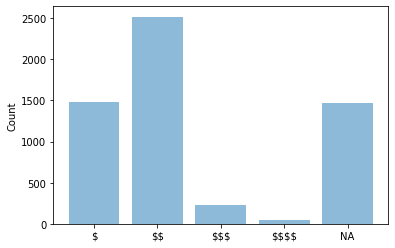

In [2024]:
objects = ("\$", "\$\$", "\$\$\$", "\$\$\$\$", "NA")
y_pos = np.arange(len(objects))

values = [np.sum((data_clean['price'] == "$").values),
          np.sum((data_clean['price'] == "$$").values),
          np.sum((data_clean['price'] == "$$$").values),
          np.sum((data_clean['price'] == "$$$$").values),
          np.sum((data_clean['price'].isna()).values)]

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')



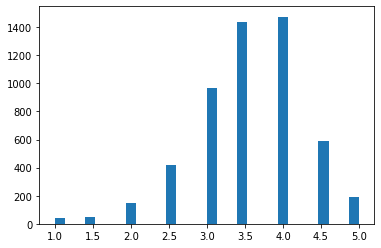

In [2032]:
x = data_clean['rating'].values
plt.hist(x, bins = 30);

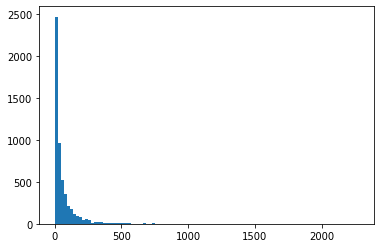

In [2035]:
x = data_clean['review_count'].values
plt.hist(x, bins = 100);

In [2043]:
np.nanmax(x)

2279.0

## Merging Back to the Original Dataframe

> Here I will create a PySpark dataframe to eventually join it back to the `rest_distinct_df` dataframe.

In [255]:
rest_distinct_info = spark.createDataFrame(data_clean)

In [256]:
rest_distinct_df.join(rest_distinct_info, rest_distinct_df.BusinessTradeName == rest_distinct_info.name, how = 'left')

Status,FOLDERYEAR,BusinessTradeName,PostalCode,Unit,House,Street,City,longitude,latitude,name,name_yelp,postal_code,unit,house,street,categories,is_claimed,is_closed,rating,review_count,price
4,20,"""Phnom Penh """"a""""...",V6A 1Z7,null,244,E Georgia St,Vancouver,-123.098236,49.278282,"""Phnom Penh """"a""""...",Phnom Penh,V6A 1Z7,null,244,E Georgia St,[[title -> Cambod...,false,false,4.0,1294.0,$$
4,20,49th Parallel Cof...,V6K 1N6,null,2198,W 4TH AV,Vancouver,-123.15455,49.267895,49th Parallel Cof...,49th Parallel Coffee,V6K 1N6,null,2198,W 4TH AV,[[title -> Coffee...,true,false,4.0,179.0,$$
4,20,49th Parallel Cof...,V6K 1N6,null,2198,W 4TH AV,Vancouver,-123.15455,49.267895,49th Parallel Cof...,49th Parallel Coffee,V5T 3G3,null,2902,MAIN ST,"[[title -> Cafes,...",true,false,4.0,469.0,$
4,20,49th Parallel Cof...,V6K 1N6,null,2198,W 4TH AV,Vancouver,-123.15455,49.267895,49th Parallel Cof...,49th Parallel Coffee,V6E 0A1,null,689,THURLOW ST,[[title -> Coffee...,true,false,4.5,201.0,$$
4,20,49th Parallel Cof...,V5T 3G3,null,2902,MAIN ST,Vancouver,-123.10078,49.25913,49th Parallel Cof...,49th Parallel Coffee,V6K 1N6,null,2198,W 4TH AV,[[title -> Coffee...,true,false,4.0,179.0,$$
4,20,49th Parallel Cof...,V5T 3G3,null,2902,MAIN ST,Vancouver,-123.10078,49.25913,49th Parallel Cof...,49th Parallel Coffee,V5T 3G3,null,2902,MAIN ST,"[[title -> Cafes,...",true,false,4.0,469.0,$
4,20,49th Parallel Cof...,V5T 3G3,null,2902,MAIN ST,Vancouver,-123.10078,49.25913,49th Parallel Cof...,49th Parallel Coffee,V6E 0A1,null,689,THURLOW ST,[[title -> Coffee...,true,false,4.5,201.0,$$
4,20,49th Parallel Cof...,V6E 0A1,null,689,THURLOW ST,Vancouver,-123.123375,49.286316,49th Parallel Cof...,49th Parallel Coffee,V6K 1N6,null,2198,W 4TH AV,[[title -> Coffee...,true,false,4.0,179.0,$$
4,20,49th Parallel Cof...,V6E 0A1,null,689,THURLOW ST,Vancouver,-123.123375,49.286316,49th Parallel Cof...,49th Parallel Coffee,V5T 3G3,null,2902,MAIN ST,"[[title -> Cafes,...",true,false,4.0,469.0,$
4,20,49th Parallel Cof...,V6E 0A1,null,689,THURLOW ST,Vancouver,-123.123375,49.286316,49th Parallel Cof...,49th Parallel Coffee,V6E 0A1,null,689,THURLOW ST,[[title -> Coffee...,true,false,4.5,201.0,$$


> quantify similarity of restaurant cuisines to see how similar restuarants in the same proximity do

## Adding more features

In [82]:
# bikeways
# find closest point from restaurant to bike lane
# metric will be distance from bikelane
bikeways_df = (spark.read
          .option('header','true')
          .option('inferSchema','true')
          .option('sep', ';')
          .csv('../data/bikeways.csv'))
bikeways_df = bikeways_df.withColumnRenamed('Unique ID', 'lane_id')\
           .withColumnRenamed('Bike Route Name', 'route_name')\
           .withColumnRenamed('Street Name', 'street_name')\
           .withColumnRenamed('Bikeway Type', 'type')\
           .withColumnRenamed('Status', 'status')\
           .withColumnRenamed('Length', 'length')\
           .withColumnRenamed('Year of Construction', 'construction_year')\
           .withColumnRenamed('Direction of Movement', 'direction')\
           .withColumnRenamed('Street Segment Types', 'street_type')\
           .withColumnRenamed('Geom', 'geom')#\
           #.withColumn('geom', regexp_extract(col('geom'), '""coordinates"": (.+)\}', 1))

In [89]:
bikeways_df.select('geom').collect()[5]

Row(geom='"{""type"": ""MultiLineString"", ""coordinates"": [[[-123.12137803835246, 49.27402761811951], [-123.11981212442065, 49.273014351119556]], [[-123.11981212442065, 49.273014351119556], [-123.11967502150573, 49.272757912544684]]]}"')

In [74]:
#[[long, lat], [long, lat]]
test = '[[[-123.04279011472578, 49.29020950254332], [-123.04243229772028, 49.28988830208881], [-123.0424239000487, 49.28988102088917], [-123.04241470835392, 49.28987311031892], [-123.04240585648783, 49.289865378626985], [-123.04239632520377, 49.28985755813151], [-123.0423870193769, 49.28984964760091], [-123.04237737403513, 49.28984191709732], [-123.04236818266261, 49.28983436543022], [-123.04235797044015, 49.28982627532632], [-123.04234866516464, 49.28981899445379], [-123.04233890714632, 49.289811353939875], [-123.04232789976578, 49.289802904318094], [-123.04231905014797, 49.28979616208651], [-123.04230021325428, 49.289782229179146], [-123.04229930638908, 49.289781509898056], [-123.04228909472738, 49.28977404944921], [-123.04227842772748, 49.289766409262754], [-123.04226844336189, 49.289759397587545], [-123.04225811764567, 49.289752027129275], [-123.04224756663228, 49.28974492660733], [-123.04223701401546, 49.289737555330596], [-123.04222623610227, 49.28973045488963], [-123.04221647766607, 49.289723892885476], [-123.0422049044399, 49.28971625302326], [-123.04219401247221, 49.28970924257255], [-123.04218402866735, 49.28970286055118], [-123.04218323480082, 49.28970241108282]], [[-123.049305865741, 49.29221907324929], [-123.04667530818253, 49.291637937788565]], [[-123.05193051661776, 49.29165215319918], [-123.049305865741, 49.29221907324929]], [[-123.06075841709702, 49.28752395573451], [-123.06008002079604, 49.28838101637829], [-123.06002111542824, 49.288429071279175]], [[-123.05649230426374, 49.290689615971935], [-123.0563148768363, 49.29072585502948]], [[-123.04335368782935, 49.29071660612908], [-123.04279011472578, 49.29020950254332]], [[-123.05929625164029, 49.28932751917025], [-123.05916887460938, 49.289488475563786], [-123.05723849383342, 49.290421876574115], [-123.0572052873451, 49.290439070179445], [-123.05717162787033, 49.29045581424119], [-123.05713740147628, 49.29047228961804], [-123.05710283348728, 49.29048831449586], [-123.05706792538398, 49.29050397972477], [-123.05703244877932, 49.29051919636507], [-123.05699663206128, 49.29053405335571], [-123.05696047512563, 49.29054845984528], [-123.05692386383265, 49.290562417688726], [-123.05688691242794, 49.29057601588147], [-123.05684961943336, 49.290589164472316], [-123.05681198632827, 49.29060195341182], [-123.05677401153241, 49.2906142036967], [-123.05673569662635, 49.29062609343004], [-123.05669715427607, 49.29063753350415], [-123.05665815757328, 49.290648524929594], [-123.05661904746657, 49.29065897578816], [-123.05657948311217, 49.290669067948926], [-123.05653980545976, 49.29067871039343], [-123.0564997862248, 49.290687903233234], [-123.05649230426374, 49.290689615971935]], [[-123.06147653288971, 49.28662136509472], [-123.06075841709702, 49.28752395573451]], [[-123.0563148768363, 49.29072585502948], [-123.05456225006097, 49.29108382175442]], [[-123.06002111542824, 49.288429071279175], [-123.05929625164029, 49.28932751917025]], [[-123.06241959184565, 49.28572638170484], [-123.06213008068546, 49.28587978393817], [-123.06147653288971, 49.28662136509472]], [[-123.05456225006097, 49.29108382175442], [-123.05193051661776, 49.29165215319918]], [[-123.04667530818253, 49.291637937788565], [-123.04405512891135, 49.29105314127263]], [[-123.04218323480082, 49.28970241108282], [-123.04154374826513, 49.28924119535919]], [[-123.04405512891135, 49.29105314127263], [-123.04394543666119, 49.29101424118774], [-123.04383857879702, 49.29097210346422], [-123.04373466550787, 49.29092690617235], [-123.04363403786014, 49.29087865009076], [-123.04353681008526, 49.29082742513649], [-123.04344332202592, 49.290773410194035], [-123.04335368782935, 49.29071660612908]]]'

In [80]:
# combine lists so it's easier to iterate
eval(test)
#np.concatenate(eval(test)).ravel()

[[[-123.04279011472578, 49.29020950254332],
  [-123.04243229772028, 49.28988830208881],
  [-123.0424239000487, 49.28988102088917],
  [-123.04241470835392, 49.28987311031892],
  [-123.04240585648783, 49.289865378626985],
  [-123.04239632520377, 49.28985755813151],
  [-123.0423870193769, 49.28984964760091],
  [-123.04237737403513, 49.28984191709732],
  [-123.04236818266261, 49.28983436543022],
  [-123.04235797044015, 49.28982627532632],
  [-123.04234866516464, 49.28981899445379],
  [-123.04233890714632, 49.289811353939875],
  [-123.04232789976578, 49.289802904318094],
  [-123.04231905014797, 49.28979616208651],
  [-123.04230021325428, 49.289782229179146],
  [-123.04229930638908, 49.289781509898056],
  [-123.04228909472738, 49.28977404944921],
  [-123.04227842772748, 49.289766409262754],
  [-123.04226844336189, 49.289759397587545],
  [-123.04225811764567, 49.289752027129275],
  [-123.04224756663228, 49.28974492660733],
  [-123.04223701401546, 49.289737555330596],
  [-123.04222623610227, 4

In [ ]:
# parking meters